# Загрузка Pandas и очистка данных

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
df = pd.read_csv('main_task.csv')  # Загружаем наши данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Из информации о DataFrame вижу что из 10 столбцов данных, 7 являются object и 3 float, так же в трех имеются пропущенные значения. Сначала рассмотрим данные с пропущенными значениями.

<AxesSubplot:>

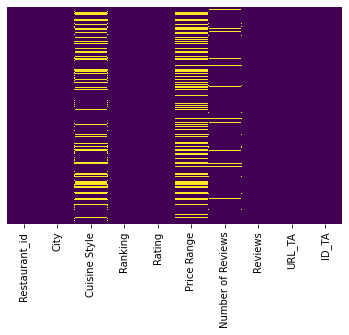

In [32]:
sns.heatmap(df.isnull(), yticklabels=False,
            cbar=False, cmap='viridis')  # Смотрим пропущенные значения

In [33]:
# Рассмотрим данные о стилях кухни в ресторанах
df['Cuisine Style']

0                  ['European', 'French', 'International']
1                                                      NaN
2        ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
3                                                      NaN
4        ['German', 'Central European', 'Vegetarian Fri...
                               ...                        
39995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
39996    ['French', 'American', 'Bar', 'European', 'Veg...
39997                                ['Japanese', 'Sushi']
39998    ['Polish', 'European', 'Eastern European', 'Ce...
39999                                          ['Spanish']
Name: Cuisine Style, Length: 40000, dtype: object

Так как данные состоят из списков с множеством значений, считаю что процесс заполнения пропусков неоправдано трудоемок и не имеет необходимости.

In [34]:
# Посмотри на данные о стиле кухни поподробнее
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: str(x).replace(
    "[", '').replace(']', '').replace(" ", '').replace("'", ''))  # уберем из данных знаки мешающие обработке посредством замены
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: str(
    x).split(','))  # разделим данные в списках через запятую
# посмотрим количество уникальных значений
len(df['Cuisine Style'].explode().unique())

126

In [35]:
# посмотрим как часто встречаются эти значения
df['Cuisine Style'].explode().value_counts()

VegetarianFriendly    11189
European              10060
nan                    9283
Mediterranean          6277
Italian                5964
                      ...  
Yunnan                    1
Burmese                   1
Salvadoran                1
Xinjiang                  1
Latvian                   1
Name: Cuisine Style, Length: 126, dtype: int64

Для построения модели из данных о стиле кухни ресторана принимаю решения взять количество стилей в ресторанах, вместо nan буду считать что в ресторане один стиль.

In [36]:
# создаем столбец с количеством стилей ресторанов
df['Cuizine_Count'] = df['Cuisine Style'].apply(lambda x: len(x))

Для дальнейшего построения модели возьмем два самых частых значения, это "VegetarianFriendly" и "European"

In [37]:
Vegetarians = []  # создадим пустой список для хранения значений
for x in df['Cuisine Style']:
    if 'VegetarianFriendly' in x:
        c = 1  # Если в данных о ресторание есть 'VegetarianFriendly', присваеваем переменной 1
    else:
        c = 0  # Если нет, 0
    Vegetarians.append(c)  # добавляем значения в наш список

In [38]:
# создадим столбец данных 'Vegetarian_Friendly' с ранее полученными значениями
df['Vegetarian_Friendly'] = pd.DataFrame(Vegetarians)

In [39]:
# проделаем те же действия с наличием европейской кухни в ресторанах
Europeans = []
for x in df['Cuisine Style']:
    if 'European' in x:
        c = 1
    else:
        c = 0
    Europeans.append(c)
df['European'] = pd.DataFrame(Europeans)

In [40]:
# Рассмотри данные о цене, из условий нам известно, что Price Range содержит диапазон цен
df['Price Range'].unique()  # посмотрим значения содержащиеся в данных о цене

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [41]:
# На графике выше видно что пропусков достаточно много, принимаю решение заполнить их самым частым значением
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [42]:
df['Price Range'] = df['Price Range'].fillna('$$ - $$$')# Заполним пропуски на '$$ - $$$' 

In [43]:
# Так как модель обучения не сможет работать с данными типа object, необходимо преобразовать их в числовые значения
# Если $-1
# Если $$ - $$$ - 2
# Если $$$$ - 3
Price = []
for x in df['Price Range']:
    if x == '$':
        c = 1
    elif x == '$$ - $$$':
        c = 2
    else:
        c = 3
    Price.append(c)
df['Price_Range_Model'] = pd.DataFrame(Price)

In [44]:
# Рассмотри данные о количестве отзывов
# посмотрим количество значений содержащихся в данных о количестве отзывов
len(df['Number of Reviews'].unique())

1460

Минимальное значение: 2.0, Максимальное значение: 9660.0, 25-й перцентиль: 9.0, 75-й перцентиль: 115.0, IQR: 106.0,  Границы выбросов: [-150.0, 274.0].


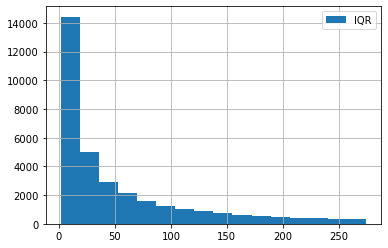

In [45]:
# Так как данные о количестве отзывов номинальны, посмотрим на их распределение
IQR = df['Number of Reviews'].quantile(
    0.75) - df['Number of Reviews'].quantile(0.25)
minimum = df['Number of Reviews'].min()
maximum = df['Number of Reviews'].max()
perc25 = df['Number of Reviews'].quantile(0.25)
perc75 = df['Number of Reviews'].quantile(0.75)

print('Минимальное значение: {},'.format(minimum),
      'Максимальное значение: {},'.format(maximum),
      '25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

df['Number of Reviews'].loc[df['Number of Reviews'].between(
    perc25 - 1.5*IQR,
    perc75 + 1.5*IQR)].hist(bins=16, label='IQR')

plt.legend()

In [46]:
# На распределении видны выбросы.
# Принимаю решения значениям выше границе выбросов присвоить случайное значение от медианы до 75-процентиля
num_rew = []
for x in df['Number of Reviews']:
    l = perc75 + 1.5*IQR
    m = df['Number of Reviews'].median()
    if x > l:
        x = random.randint(m, l)
    num_rew.append(x)
df['Number of Reviews'] = pd.DataFrame(num_rew)

In [47]:
# Пустые значения заполним средним значением по данным
df['Number of Reviews'] = df['Number of Reviews'].fillna(
    int(df['Number of Reviews'].mean()))

In [48]:
# Для обучения модели нормализуем данные о количестве отзывов при помощи MinMax нормализации
df['Number of Reviews'] = (df['Number of Reviews']-df['Number of Reviews'].min())/(df['Number of Reviews'].max() -
                                                                                   df['Number of Reviews'].min())

Минимальное значение: 1.0, Максимальное значение: 16444.0, 25-й перцентиль: 973.0, 75-й перцентиль: 5260.0, IQR: 4287.0,  Границы выбросов: [-5457.5, 11690.5].


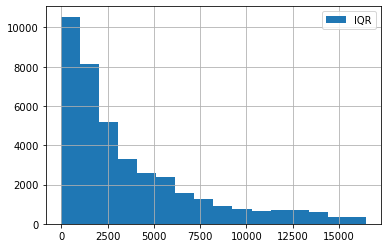

In [49]:
# посомтри на распределение данных о месте ресторна по городу
IQR = df.Ranking.quantile(
    0.75) - df.Ranking.quantile(0.25)
minimum = df.Ranking.min()
maximum = df.Ranking.max()
perc25 = df.Ranking.quantile(0.25)
perc75 = df.Ranking.quantile(0.75)

print('Минимальное значение: {},'.format(minimum),
      'Максимальное значение: {},'.format(maximum),
      '25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

df.Ranking.hist(bins=16, label='IQR')

plt.legend()

На распределении видны выбросы, но здравый смысл говорит что ресторанов в городах может быть разное количество, из-за этого и места по городу могут сильно разница. Поэтому принимаю решения только нормализовать данные для модели.

In [50]:
# Нормализуем при помощи MinMax нормализации
df['Ranking'] = (df['Ranking']-df['Ranking'].min()) / \
    (df['Ranking'].max()-df['Ranking'].min())

In [51]:
# Рассмотрим данные о расположении (Городе) в котором находится ресторан
df.City.value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

Вижу что большинство городов, это столицы. Создадим столбец с отношением к столице

In [52]:
# Создаю список столиц
Capital = ['London', 'Berlin', 'Paris', 'Madrid', 'Rome', 'Prague', 'Lisbon', 'Vienna',
           'Amsterdam', 'Brussels', 'Stockholm', 'Budapest', 'Warsaw', 'Dublin', 'Copenhagen',
           'Athens', 'Edinburg', 'Oslo', 'Helsinki', 'Bratislava', 'Luxemburg', 'Ljubljana']

In [53]:
# Если ресторан находится в столице, присваиваю 1, если нет - 0.
in_Capital = []
for x in df.City:
    if x in Capital:
        x = 1
    else:
        x = 0
    in_Capital.append(x)
# Добавим получившейся список в наш DataFrame
df['In_Capital'] = pd.DataFrame(in_Capital)

In [54]:
# Для того чтоб максимально использовать данные о местоположении ресторана, создадим Dummy-переменные.
pd.get_dummies(df.City).shape

(40000, 31)

In [55]:
# Всего 31 значение, принимаю решение использовать все для создания Dummy-переменных
df = pd.get_dummies(df, columns=['City'])

,Ranking,Rating,Number of Reviews,Cuizine_Count,Vegetarian_Friendly,European,Price_Range_Model,In_Capital,City_Amsterdam,City_Athens,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
Ranking,1.000000,-0.368371,-0.276472,-0.320250,-0.300139,-0.279235,-0.026525,0.233412,-0.094372,-0.095177,...,-0.093938,-0.090281,-0.082608,0.328009,-0.083389,-0.043718,-0.094931,-0.092039,-0.095860,-0.091098
Rating,-0.368371,1.000000,-0.009286,0.120059,0.128356,0.047848,-0.028588,0.016783,0.034535,0.044792,...,0.012207,0.031603,-0.014680,-0.028288,0.011442,0.083082,-0.026604,0.022037,0.019617,0.008197
Number of Reviews,-0.276472,-0.009286,1.000000,0.543016,0.510245,0.317597,0.095761,-0.007311,0.022301,-0.024808,...,-0.022029,0.010403,-0.007234,0.037634,-0.034438,0.130352,-0.034810,-0.030095,-0.042118,-0.006405
Cuizine_Count,-0.320250,0.120059,0.543016,1.000000,0.691884,0.484885,0.003177,0.019637,0.063322,-0.002088,...,-0.013670,0.006689,0.022457,-0.095268,0.022787,0.075791,-0.009356,0.012780,-0.005405,0.024620
Vegetarian_Friendly,-0.300139,0.128356,0.510245,0.691884,1.000000,0.266105,0.019858,0.008271,0.056621,-0.011052,...,0.018927,-0.017572,0.000174,-0.053154,-0.041409,0.090783,-0.005650,0.008224,-0.011407,0.028289
European,-0.279235,0.047848,0.317597,0.484885,0.266105,1.000000,0.096237,0.036943,0.080790,-0.045861,...,-0.009590,0.081925,0.019577,0.002708,0.107247,-0.069483,0.020238,0.048552,0.023361,0.032860
Price_Range_Model,-0.026525,-0.028588,0.095761,0.003177,0.019858,0.096237,1.000000,-0.001809,-0.000058,-0.020393,...,0.023440,-0.026726,0.019273,0.045851,-0.019972,-0.054426,0.031190,0.013234,0.002334,0.026925
In_Capital,0.233412,0.016783,-0.007311,0.019637,0.008271,0.036943,-0.001809,1.000000,0.098906,0.074774,...,-0.255232,-0.192517,0.058366,0.221134,0.114537,0.138593,0.085652,0.102590,0.080553,-0.197215
City_Amsterdam,-0.094372,0.034535,0.022301,0.063322,0.056621,0.080790,-0.000058,0.098906,1.000000,-0.021098,...,-0.025244,-0.019041,-0.016469,-0.062396,-0.032318,-0.039106,-0.024168,-0.028947,-0.022729,-0.019506
City_Athens,-0.095177,0.044792,-0.024808,-0.002088,-0.011052,-0.045861,-0.020393,0.074774,-0.021098,1.000000,...,-0.019085,-0.014395,-0.012450,-0.047171,-0.024432,-0.029564,-0.018271,-0.021884,-0.017183,-0.014746


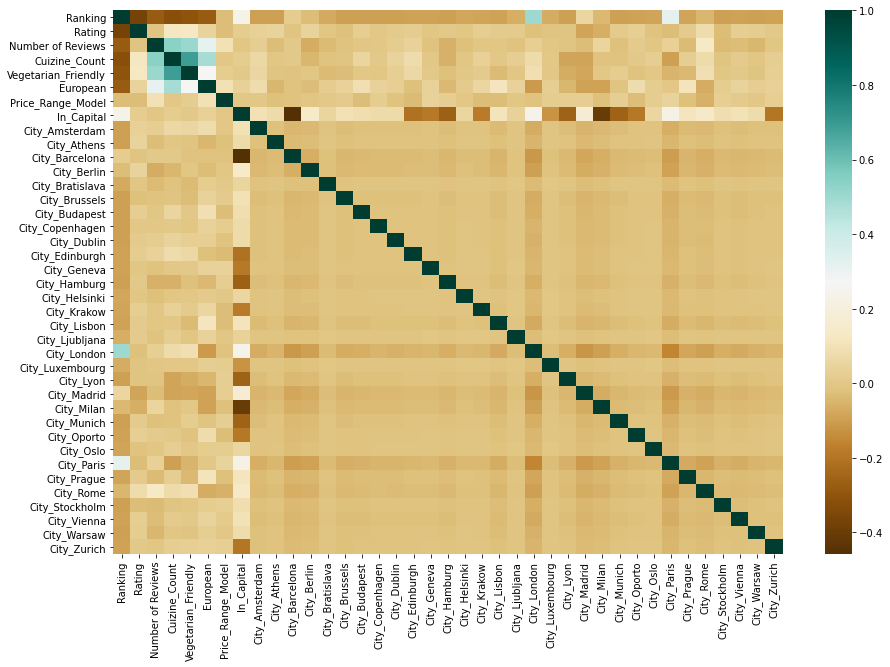

In [56]:
# Построим матрицу корреляций для наших данных
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['Restaurant_id'], axis=1).corr(),cmap="BrBG")
df.drop(['Restaurant_id'], axis=1).corr()

In [57]:
# На основе графика корреляций принимю решение оставить все данные для модели
# Удалим столбцы которые не нужны для построения модели
df.drop(["Cuisine Style", "Price Range", "Reviews",
         "URL_TA", "ID_TA"], axis=1, inplace=True)

In [58]:
# Посмотрим на получившиеся данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant_id        40000 non-null  object 
 1   Ranking              40000 non-null  float64
 2   Rating               40000 non-null  float64
 3   Number of Reviews    40000 non-null  float64
 4   Cuizine_Count        40000 non-null  int64  
 5   Vegetarian_Friendly  40000 non-null  int64  
 6   European             40000 non-null  int64  
 7   Price_Range_Model    40000 non-null  int64  
 8   In_Capital           40000 non-null  int64  
 9   City_Amsterdam       40000 non-null  uint8  
 10  City_Athens          40000 non-null  uint8  
 11  City_Barcelona       40000 non-null  uint8  
 12  City_Berlin          40000 non-null  uint8  
 13  City_Bratislava      40000 non-null  uint8  
 14  City_Brussels        40000 non-null  uint8  
 15  City_Budapest        40000 non-null 

Считаю что данные достаточно очищенны и обработанны для создания и обучения модели.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [59]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [60]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [61]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [62]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [63]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [64]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2310315
